In [1]:
!pip install vaderSentiment
!pip install tabulate

In [1]:
import warnings

import numpy as np
import pandas as pd
import keras.utils as U
import keras.models as M
import keras.layers as L
import keras.optimizers as opt
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import Counter
from utils import plot_counter, process_acled_csv, acledLocations
from sklearn.ensemble import ExtraTreesClassifier
from nlp_utils import get_sentiment, get_features, make_predictions
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from doc_utils import get_docs_by_location, get_docs_by_day, interleave_location_and_date, get_headlines_sentiment

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("../../data/india-news-headlines.csv")

In [3]:
labels = process_acled_csv("../../data/1900-01-01-2019-05-03-India.csv",
                           top_locations=30,
                           end="01-may-2019")

Data from 2016-01-01 to 2019-05-01  & Number of days - 1217


In [4]:
df["created_at"] = df["publish_date"]
del df["publish_date"]

In [5]:
df.head(5)

,headline_category,headline_text,created_at
0,sports.wwe,win over cena satisfying but defeating underta...,20010101
1,bollywood,Raju Chacha,20010102
2,unknown,Status quo will not be disturbed at Ayodhya; s...,20010102
3,unknown,Fissures in Hurriyat over Pak visit,20010102
4,unknown,America's unwanted heading for India?,20010102


In [15]:
plt.rcParams["figure.figsize"] = (20, 5)

In [16]:
headline_df = df.headline_category.apply(lambda x : x.split('.')[0] if len(x.split('.')) == 1 else x.split('.')[1])

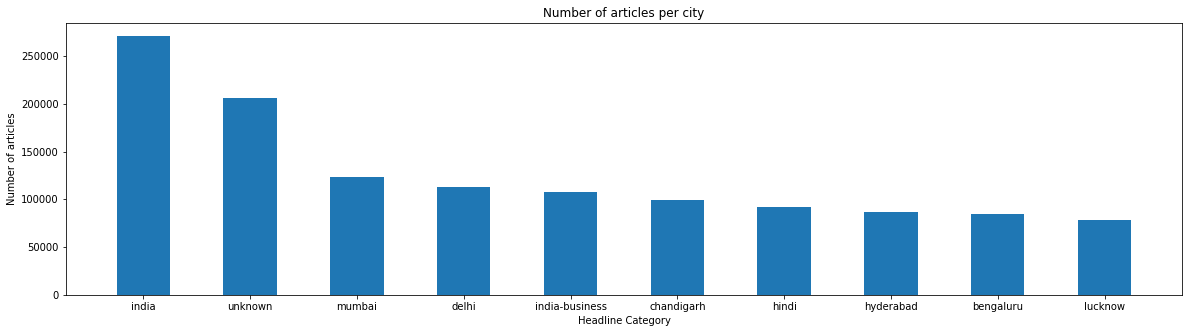

In [17]:
plot_counter(headline_df, 
             title="Number of articles per city",
             xlabel="Headline Category",
             ylabel="Number of articles")

In [103]:
latest_headlines = pd.read_csv("../../data/headlines_and_location.csv")

In [104]:
latest_headlines.head(5)

,Unnamed: 0,title,text,location,date
0,0,Govt's new policy is to choke democratic space...,SRINAGAR: Peoples Democratic Party (PDP) presi...,SRINAGAR,2018-09-29
1,1,Brexit mayday? PM May's ministers move to oust...,LONDON: British Prime Minister Theresa May’s t...,LONDON,2018-09-29
2,2,Polls open in first Thai general election sinc...,BANGKOK: Polls opened Sunday for the first Tha...,BANGKOK,2018-09-29
3,3,“I have admired Aishwarya Rai since childhood”,Miss India South 2019: Crowning Moments 1 6 Mi...,Miss India South 2019,2018-09-29
4,4,"No place for violence in democracy, says Naidu",Visakhapatnam: Chief minister N Chandrababu Na...,Visakhapatnam,2018-09-29


In [20]:
def convert_to_datetime(df):
    """
    Input - A DF to convert df.publish_dates to to_datetime
    Returns - A converted DF
    """
    dates = df.created_at
    dates = dates.apply(lambda x: str(x))
    dates = pd.to_datetime(dates)
    df['created_at'] = dates
    return df


def filter_headlines(df, keywords):
    """
    Input - A DF for filtering headlines based on
            keywords
    Returns - Filtered DFA
    """
    assert(keywords != None)
    assert(len(keywords) != 0)

    if isinstance(keywords, str):
        keywords = [keywords]

    resultant_df = pd.DataFrame(df.head(1).copy(deep=True), df.columns)

    # Iteratively apply the filter for each word
    for keyword in keywords:
        temp_df = df[df['headline_text'].str.contains(keyword, na=False)]
        print(keyword, "found in", temp_df.shape[0], "rows")
        resultant_df = resultant_df.append(temp_df.copy(deep=True))

    curr_len = len(resultant_df)
    resultant_df.drop_duplicates(inplace=True)

    print("Dropped", curr_len - len(resultant_df), "duplicate rows")

    return resultant_df

In [112]:
df = convert_to_datetime(df)

filtered_df = filter_headlines(
    df, ['bjp', 'govt', 'government', 'elect',
         'riot', 'protest', 'unrest', 'politic',
         'violen', 'scam', 'gang', 'modi', 'attac'])
print("Current shape:", filtered_df.shape)

bjp found in 150 rows
govt found in 35274 rows
government found in 11661 rows
elect found in 22416 rows
riot found in 5056 rows
protest found in 18492 rows
unrest found in 532 rows
politic found in 10998 rows
violen found in 5588 rows
scam found in 11700 rows
gang found in 9349 rows
modi found in 890 rows
attac found in 22155 rows
Dropped 4634 duplicate rows
Current shape: (149630, 3)


In [106]:
latest_headlines.location = latest_headlines.location.str.lower()
latest_headlines["date"] = pd.to_datetime(latest_headlines["date"])
print(latest_headlines.head(5))

# Get news starting from 2016 and with city tag
temp = None
for city in acledLocations:
    if temp is None:
        temp = latest_headlines[latest_headlines.location.str.contains(city.lower(), na=False)]
        temp["headline_category"] = "city." + city.lower()
    else:
        temp_ = latest_headlines[latest_headlines.location.str.contains(city.lower(), na=False)]
        temp_["headline_category"] = "city." + city.lower()
        temp = temp.append(temp_)
        
    temp = temp[temp.date.dt.year > 2015]
latest_headlines = temp

   Unnamed: 0                                              title  \
0           0  Govt's new policy is to choke democratic space...   
1           1  Brexit mayday? PM May's ministers move to oust...   
2           2  Polls open in first Thai general election sinc...   
3           3     “I have admired Aishwarya Rai since childhood”   
4           4     No place for violence in democracy, says Naidu   

                                                text               location  \
0  SRINAGAR: Peoples Democratic Party (PDP) presi...               srinagar   
1  LONDON: British Prime Minister Theresa May’s t...                 london   
2  BANGKOK: Polls opened Sunday for the first Tha...                bangkok   
3  Miss India South 2019: Crowning Moments 1 6 Mi...  miss india south 2019   
4  Visakhapatnam: Chief minister N Chandrababu Na...          visakhapatnam   

        date  
0 2018-09-29  
1 2018-09-29  
2 2018-09-29  
3 2018-09-29  
4 2018-09-29  


In [113]:
# Get news from 2016 and with city tag
temp = None
for city in acledLocations:
    if temp is None:
        temp = filtered_df[filtered_df.headline_category.str.contains(city.lower(), na=False)]
        temp["headline_category"] = "city." + city.lower()
    else:
        temp_ = filtered_df[filtered_df.headline_category.str.contains(city.lower(), na=False)]
        temp_["headline_category"] = "city." + city.lower()
        temp = temp.append(temp_)
        
    temp = temp[temp.created_at.dt.year > 2015]

filtered_df = temp
print("Current shape:", filtered_df.shape)

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Current shape: (19280, 3)


In [24]:
filtered_df.head(5)

,headline_category,headline_text,created_at
2214065,city.jammu,J-K govt raises PF ceiling limit to Rs 15;000,2016-01-05
2221724,city.jammu,Farooq says NC ready to consider tie-up with B...,2016-01-17
2223141,city.jammu,No official communication from PDP over govt. ...,2016-01-19
2225185,city.jammu,Successive govts sold false dreams to Kashmiri...,2016-01-22
2234353,city.jammu,NDA govt re-branding UPA schemes to take credi...,2016-02-04


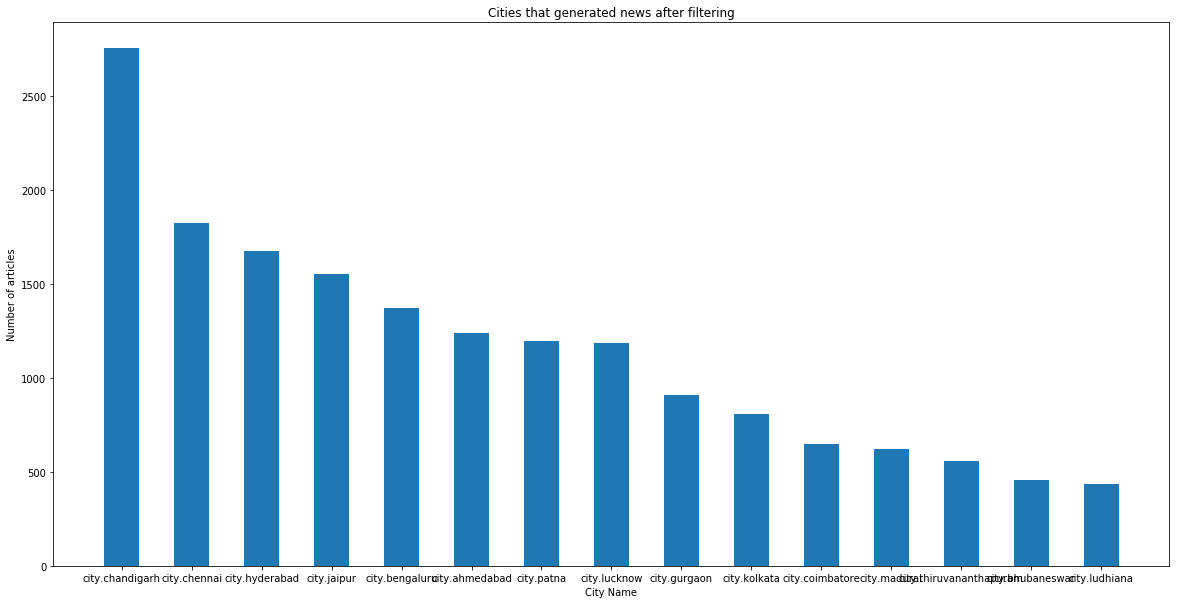

In [25]:
filtered_df.sort_values(by="created_at", inplace=True)

plot_counter(filtered_df.headline_category, num_elements=15, 
             title="Cities that generated news after filtering",
             xlabel="City Name", ylabel="Number of articles")

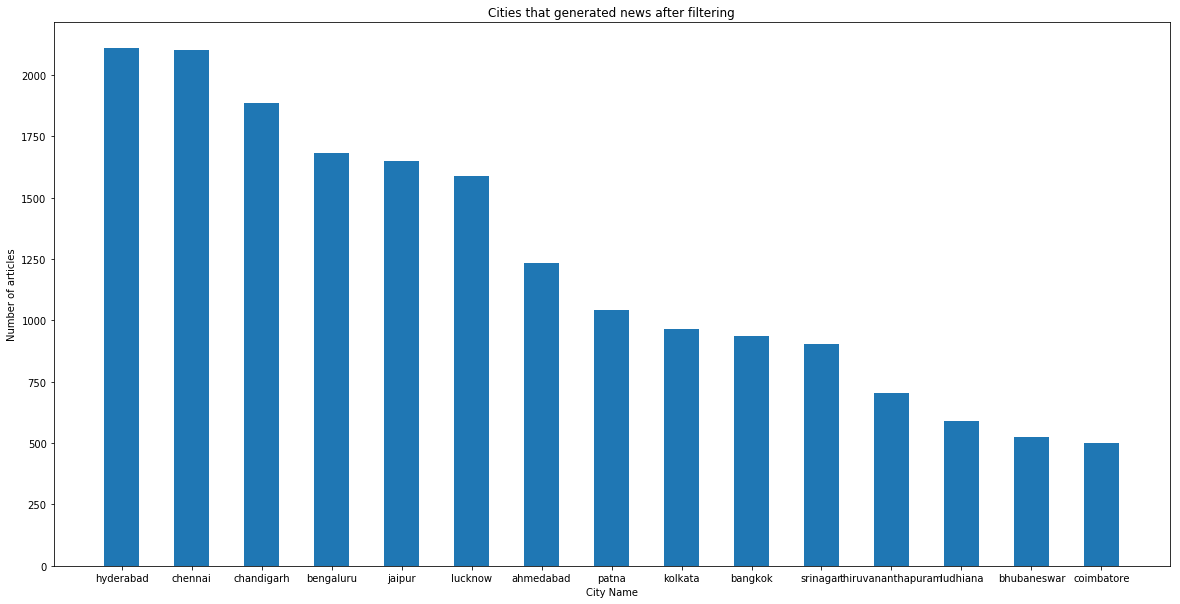

In [108]:
plot_counter(latest_headlines.location, num_elements=15, 
             title="Cities that generated news after filtering",
             xlabel="City Name", ylabel="Number of articles")

In [114]:
filtered_df.columns

Index(['headline_category', 'headline_text', 'created_at'], dtype='object')

In [110]:
latest_headlines.drop(columns=["Unnamed: 0", "location", "text"], inplace=True)
latest_headlines.columns = ["headline_text", "created_at", "headline_category"]

In [117]:
filtered_df = filtered_df.append(latest_headlines)

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [118]:
filtered_df.shape

,created_at,headline_category,headline_text
2214065,2016-01-05,city.jammu,J-K govt raises PF ceiling limit to Rs 15;000
2221724,2016-01-17,city.jammu,Farooq says NC ready to consider tie-up with B...
2223141,2016-01-19,city.jammu,No official communication from PDP over govt. ...
2225185,2016-01-22,city.jammu,Successive govts sold false dreams to Kashmiri...
2234353,2016-02-04,city.jammu,NDA govt re-branding UPA schemes to take credi...
2235725,2016-02-06,city.jammu,No govt if Centre does not support; indicates ...
2242731,2016-02-16,city.jammu,JK govt accepts resignation of AG; 2 AAGs; DAG
2242732,2016-02-16,city.jammu,Panun Kashmir hits out at J&K govt
2243386,2016-02-17,city.jammu,J&K govt restricts speed of school buses to 50...
2243388,2016-02-17,city.jammu,Cong asks PDP; BJP to shun public posturing on...


In [126]:
cities = pd.unique(filtered_df.headline_category)
for city in cities:
    city_df = filtered_df[filtered_df.headline_category == city]
    city_df["created_at"] = pd.to_datetime(city_df["created_at"])

    
    print("Min date:", city_df["created_at"].min())
    print("Max date:", city_df["created_at"].max())
    print()

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Min date: 2016-01-03 00:00:00
Max date: 2019-04-10 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-05-02 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-04-14 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-05-01 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-04-11 00:00:00

Min date: 2016-01-09 00:00:00
Max date: 2019-03-28 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-04-03 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-05-02 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-05-01 00:00:00

Min date: 2016-01-02 00:00:00
Max date: 2019-04-23 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-05-01 00:00:00

Min date: 2016-01-02 00:00:00
Max date: 2019-04-28 00:00:00

Min date: 2016-01-02 00:00:00
Max date: 2019-05-02 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-05-04 00:00:00

Min date: 2016-01-01 00:00:00
Max date: 2019-04-24 00:00:00

Min date: 2016-01-02 00:00:00
Max date: 2019-04-09 00:00:00

Min date: 2016-01-01 00:

In [129]:
# Dictify cities
cities = {x: (x.split(".")[1]).title() for x in cities if "." in x}

# Delhi fix
cities["city.delhi"] = "Delhi-New Delhi"

In [130]:
cities_set = set(cities.values())
acled_set = set(labels.keys())
common_locations = cities_set & acled_set

In [131]:
common_locations

{'Agartala',
 'Ahmedabad',
 'Amritsar',
 'Bathinda',
 'Bengaluru',
 'Bhubaneswar',
 'Chandigarh',
 'Chennai',
 'Coimbatore',
 'Dehradun',
 'Delhi-New Delhi',
 'Guwahati',
 'Hyderabad',
 'Imphal',
 'Jaipur',
 'Jalandhar',
 'Jammu',
 'Karnal',
 'Kolkata',
 'Lucknow',
 'Ludhiana',
 'Madurai',
 'Patiala',
 'Patna',
 'Puducherry',
 'Ranchi',
 'Sangrur',
 'Shimla',
 'Srinagar',
 'Thiruvananthapuram'}

In [147]:
warnings.filterwarnings("ignore")
start_date, end_date = pd.to_datetime("01-jan-2016"), pd.to_datetime("01-may-2019")

try:
    temp = filtered_df.headline_category
    filtered_df["finallocation"] = temp
    del filtered_df["headline_category"]
except:
    pass

filtered_df = get_headlines_sentiment(filtered_df)

location_date_dict = interleave_location_and_date(filtered_df, start_date, end_date)
warnings.filterwarnings("default")

In [148]:
location_feature_dict = {}
for location in location_date_dict:
    city = cities.get(location)
    if city is not None and city in common_locations:
        location_feature_dict[city] = get_features(location_date_dict[location])

In [149]:
location_feature_dict.keys()

dict_keys(['Jammu', 'Srinagar', 'Dehradun', 'Chandigarh', 'Ludhiana', 'Amritsar', 'Imphal', 'Lucknow', 'Kolkata', 'Guwahati', 'Chennai', 'Bhubaneswar', 'Bengaluru', 'Patna', 'Jaipur', 'Coimbatore', 'Hyderabad', 'Ranchi', 'Thiruvananthapuram', 'Shimla', 'Ahmedabad', 'Puducherry', 'Agartala', 'Madurai', 'Bathinda', 'Jalandhar', 'Patiala', 'Sangrur', 'Karnal'])

In [152]:
model = ExtraTreesClassifier(n_estimators=400, n_jobs=-1)
def make_predictions(location_features_dict, labels, model=None, permute=False, lead_days=2, days_window=5):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
    Returns - None
    """
    # Table for presenting on tabulate
    result_table = []

    # Suppress warnings for divide-by-zero error
    warnings.filterwarnings("ignore")

    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())

    # Sorted for clarity
    common_locations = sorted(list(common_locations))

    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)

        
        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]

        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))

        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]

        # Default model
        if model is None:
            model = create_model(6)


        # Fit the train data
        model.fit(xtrain, ytrain)

        # Make predictions
        ypred_train = model.predict(xtrain)
        ypred = model.predict(xtest)

        
        # Compute metrics
        test_accuracy = accuracy_score(ytest, ypred)
        precision = precision_score(ytest, ypred)
        recall = recall_score(ytest, ypred)
        f1 = f1_score(ytest, ypred)
        
        # Add row to result_table
        result_row = [common_location, np.round(test_accuracy, 2),
                      np.round(precision, 2), np.round(recall, 2),
                      np.round(f1, 2)
                     ]
        result_table.append(result_row)

    # Average stats
    # Turns out median is kind of useless
    result_table_copy = (np.array(result_table)[:, 1:]).astype(np.float32)
    averages = np.round(np.mean(result_table_copy, axis=0), 2)
    
    # Add them to the existing result table
    result_table.append(["Average"] + averages.tolist())
    resuk

    # Print tabulated result
    header = ["Location", "Test Accuracy", "Precision", "Recall", "F1 Score"]

    print(
        tabulate(result_table,
                 header,
                 tablefmt="pipe",
                 stralign="center")
    )

    # Unsuppress warning
    warnings.filterwarnings("default")

def create_model(num_features):
    """
    num_features - Number of features for input_shape
    """
    model = M.Sequential()
    model.add(M.InputLayer(input_shape=(num_features, )))
    model.add(L.Dense(100, activation='relu'))
    model.add(L.Dense(50, activation='relu'))
    model.add(L.Dense(2, activation='relu'))
    model.add(L.Softmax())
    
    model.compile(opt.Adam(0.01), loss="categorical_crossentropy")
    return model
make_predictions(location_feature_dict, labels, model=model, permute=False)

|      Location      |   Test Accuracy |   Precision |   Recall |   F1 Score |
|:------------------:|----------------:|------------:|---------:|-----------:|
|      Agartala      |            0.37 |        0.67 |     0.05 |       0.09 |
|     Ahmedabad      |            0.53 |        0.51 |     0.37 |       0.43 |
|      Amritsar      |            0.95 |        0.96 |     0.99 |       0.97 |
|      Bathinda      |            0.98 |        0.98 |     1    |       0.99 |
|     Bengaluru      |            0.71 |        0.88 |     0.77 |       0.82 |
|    Bhubaneswar     |            0.76 |        0.81 |     0.91 |       0.86 |
|     Chandigarh     |            0.95 |        0.96 |     0.99 |       0.97 |
|      Chennai       |            0.72 |        0.79 |     0.88 |       0.83 |
|     Coimbatore     |            0.64 |        0.68 |     0.88 |       0.77 |
|      Dehradun      |            0.6  |        0.6  |     0.97 |       0.74 |
|      Guwahati      |            0.79 |        0.86

In [153]:
def plot_result_df(result_df, location):
    
    # Plot location
    plt.title(location)
    
    # X-axis 
    plt.xlabel("Batch #")
    
    # Y-axis
    plt.ylabel("Metric value")
    
    # Set color for lines
    plt.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])
    
    # Get x-axis
    test_range = np.arange(result_df.shape[0])
    
    # Iter through each result & plot
    for header in result_df.columns:
        plt.plot(test_range, result_df[header])
        
    # Add a legend for ease of use
    plt.legend(result_df.columns, loc="upper left")
    
    # Actually plot
    plt.show()

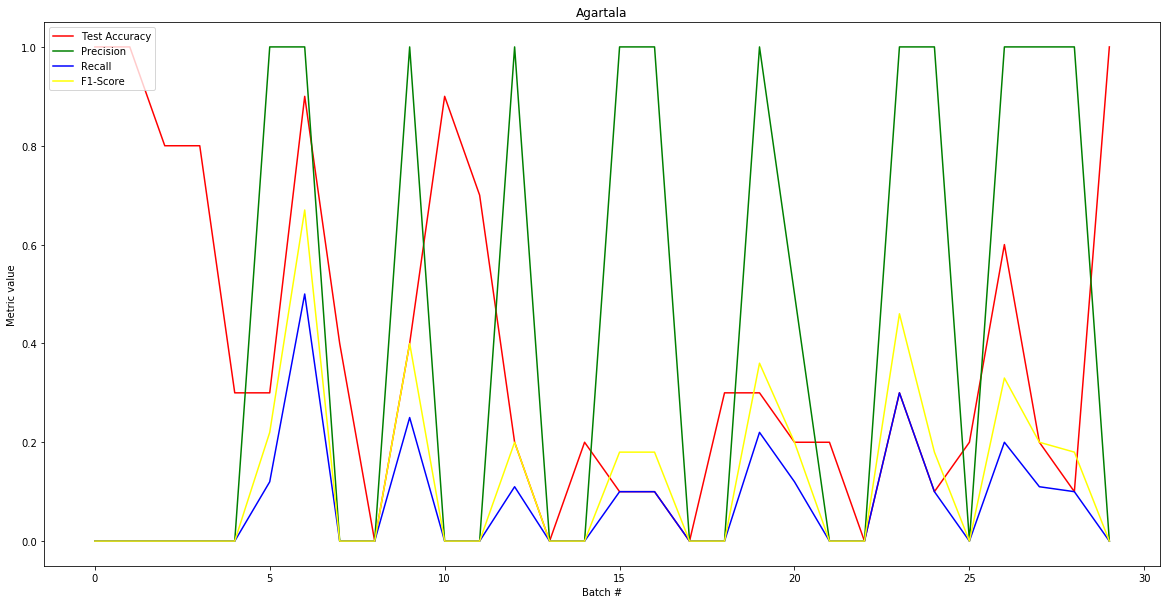

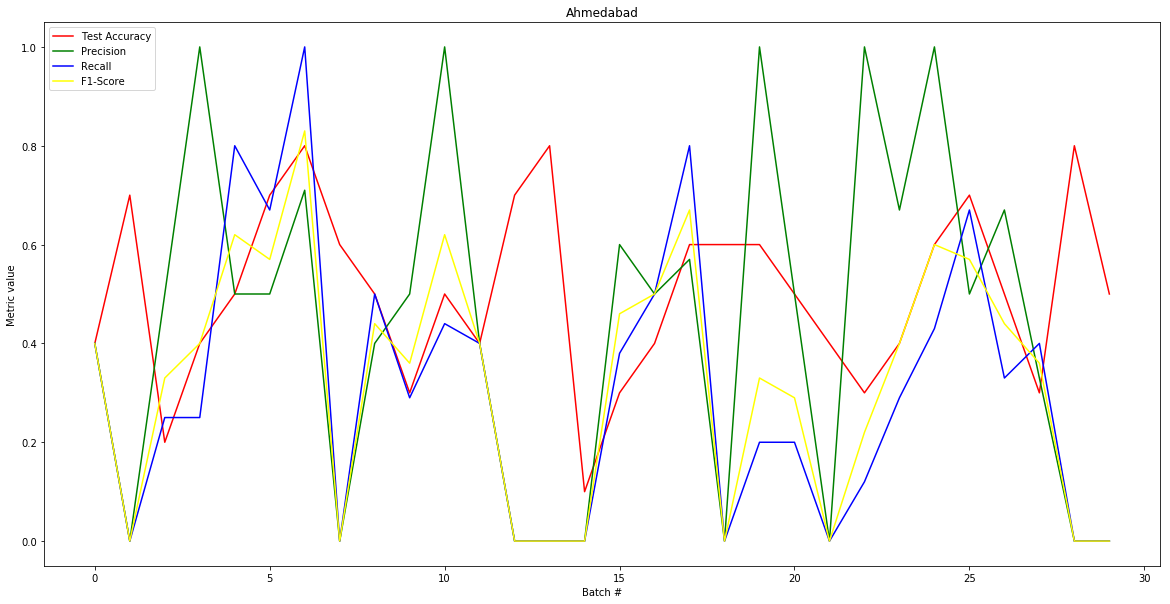

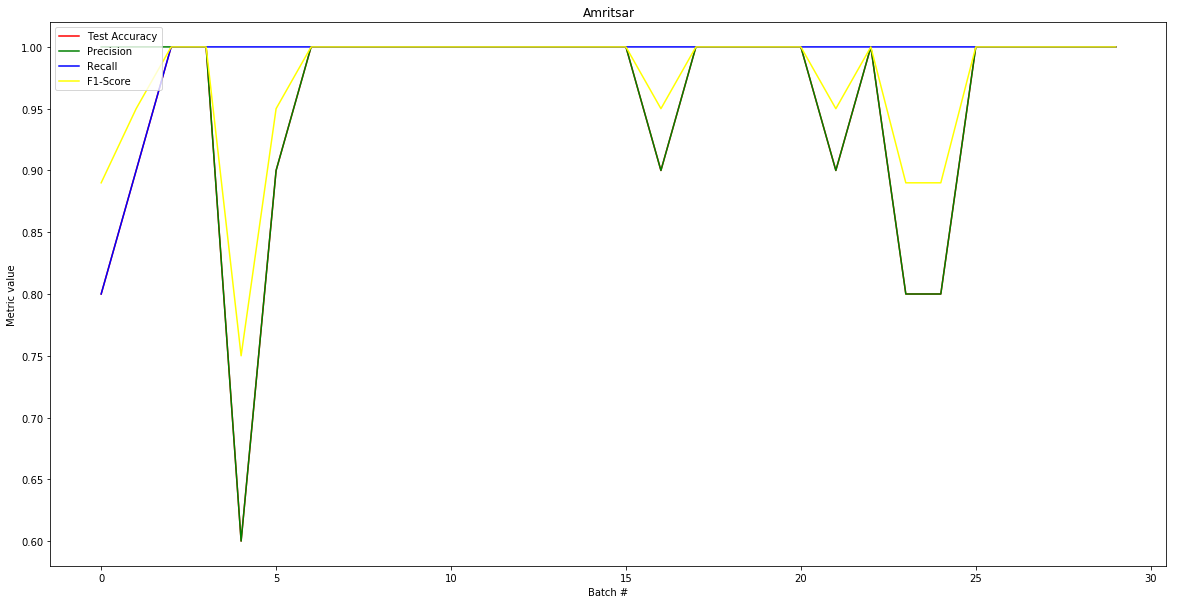

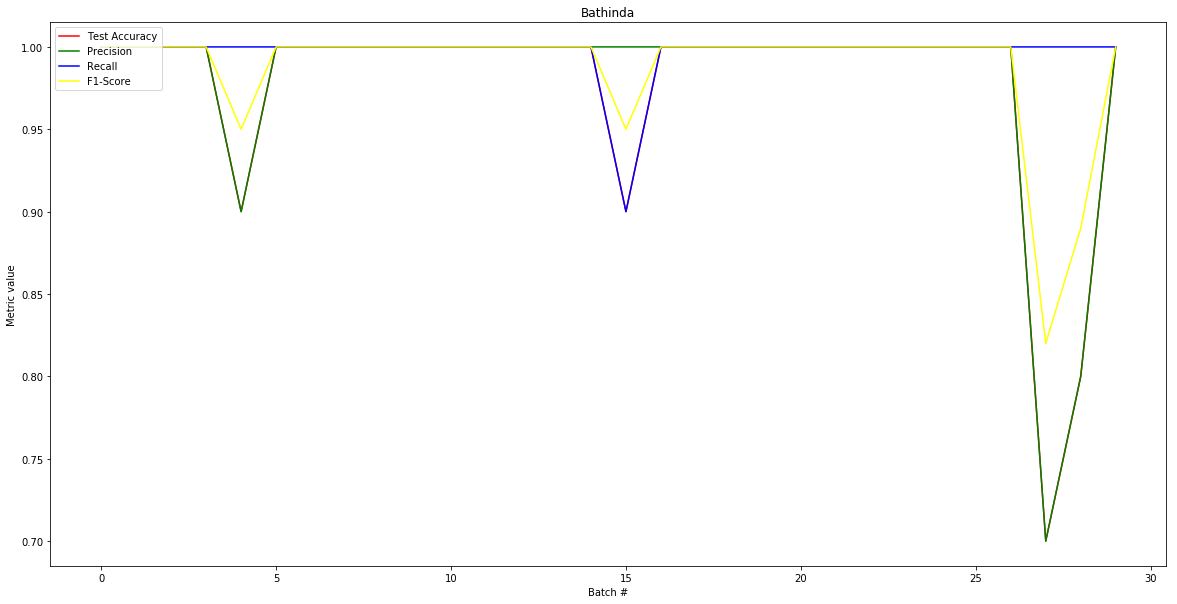

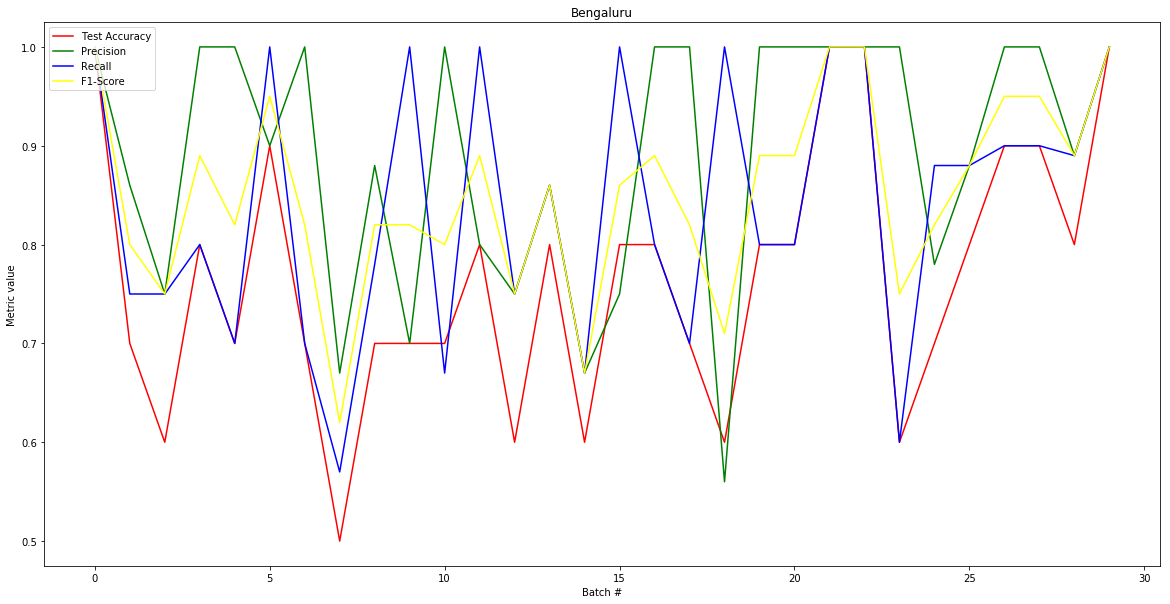

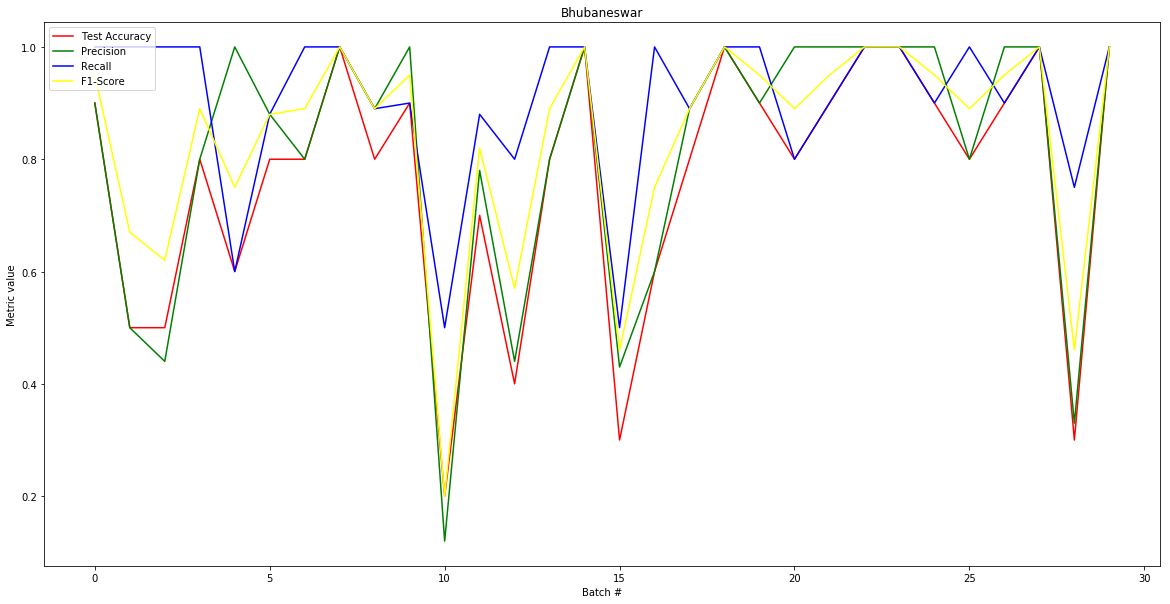

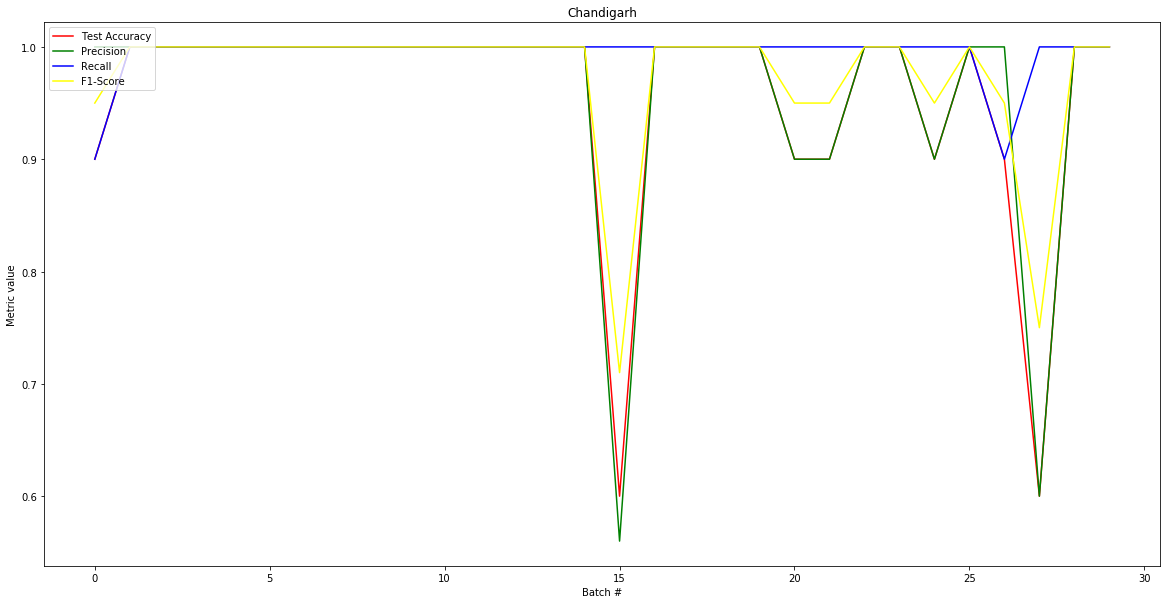

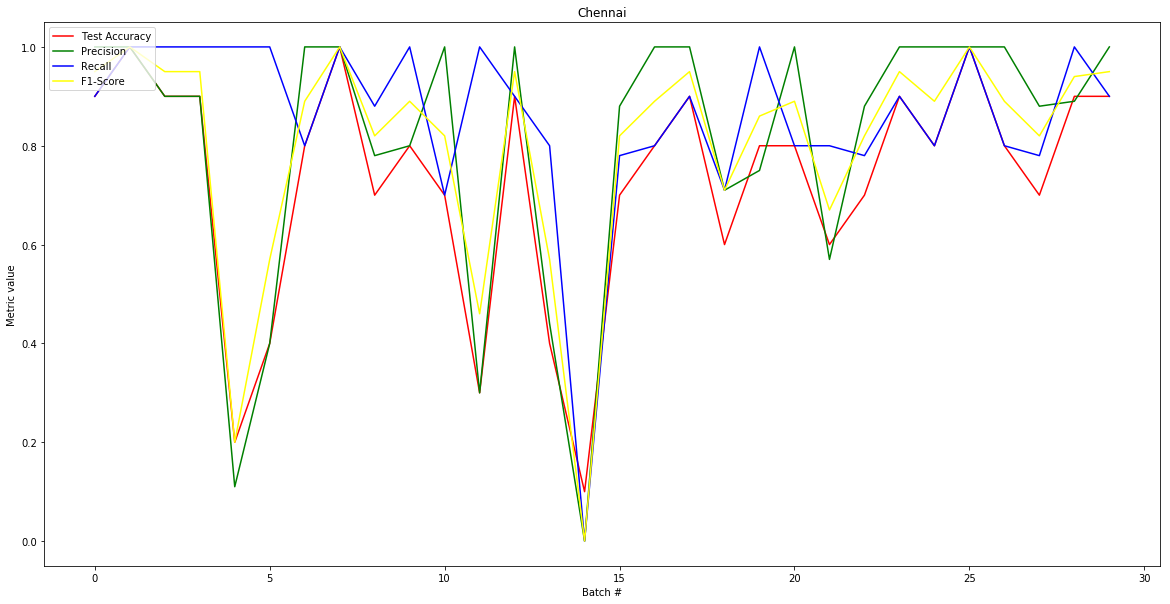

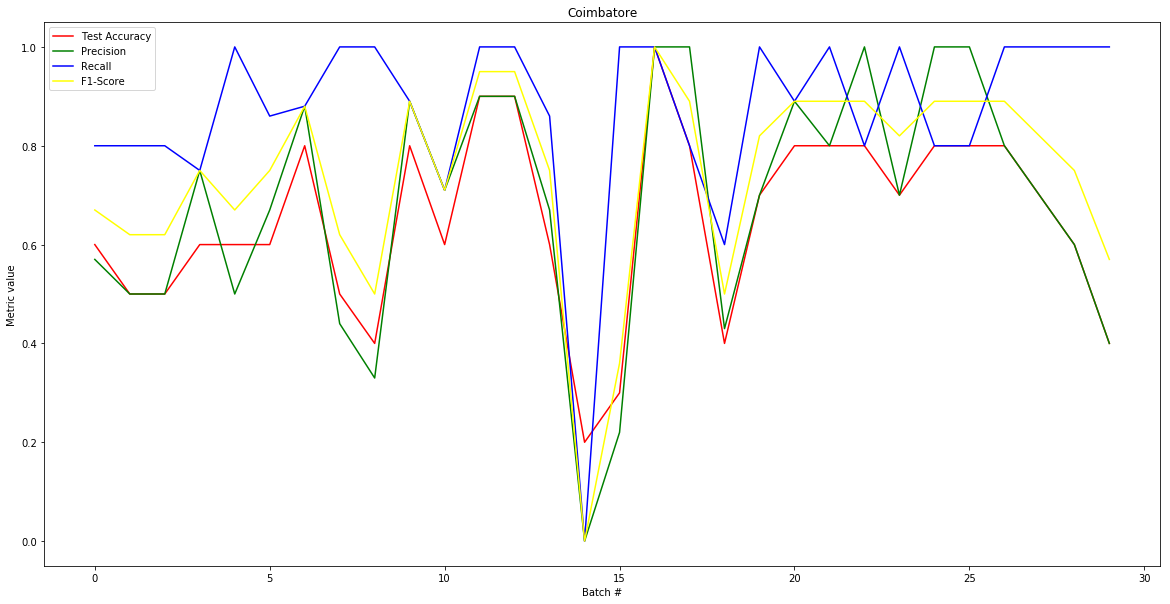

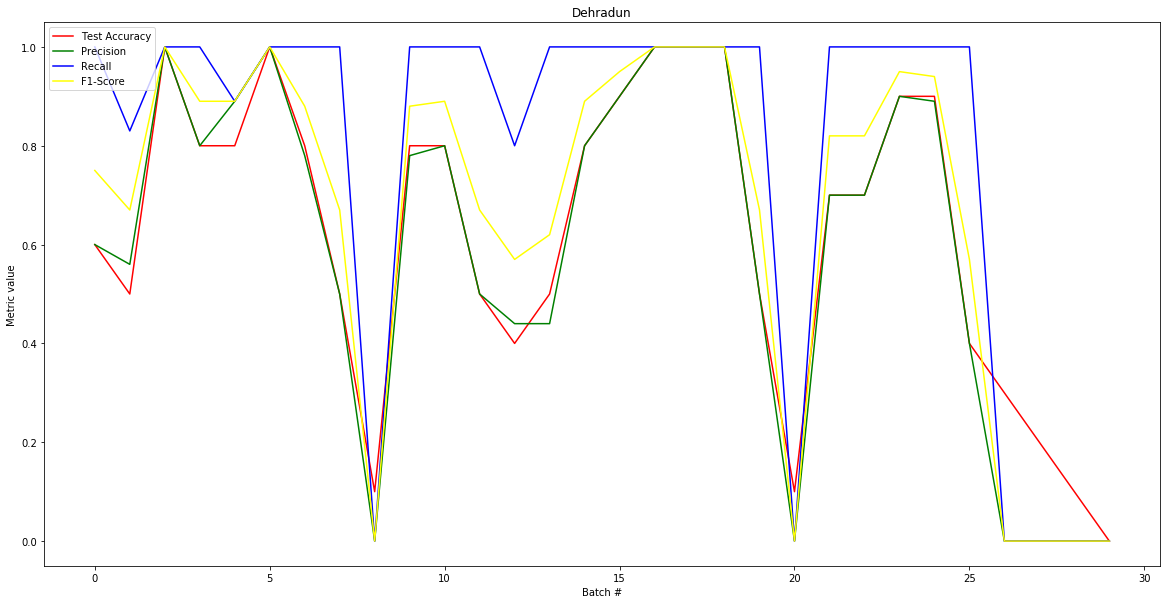

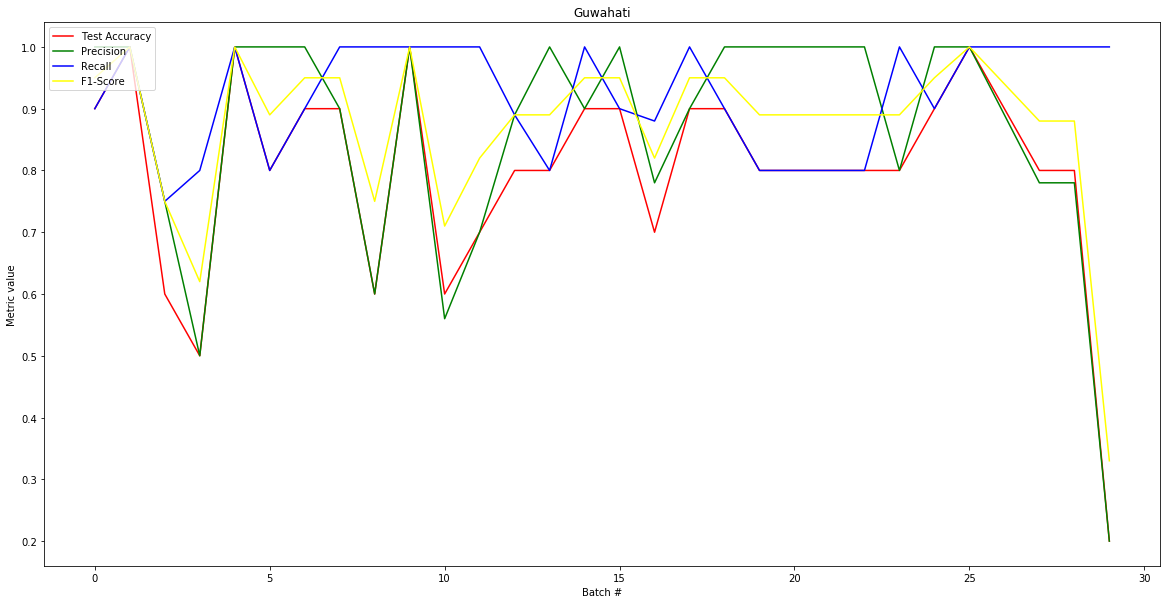

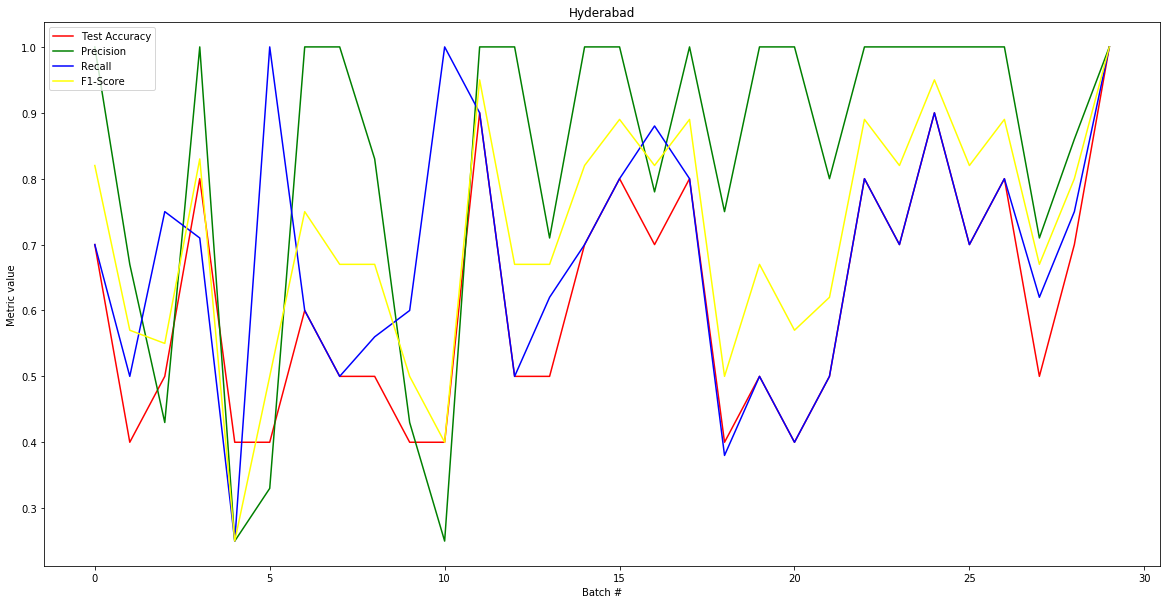

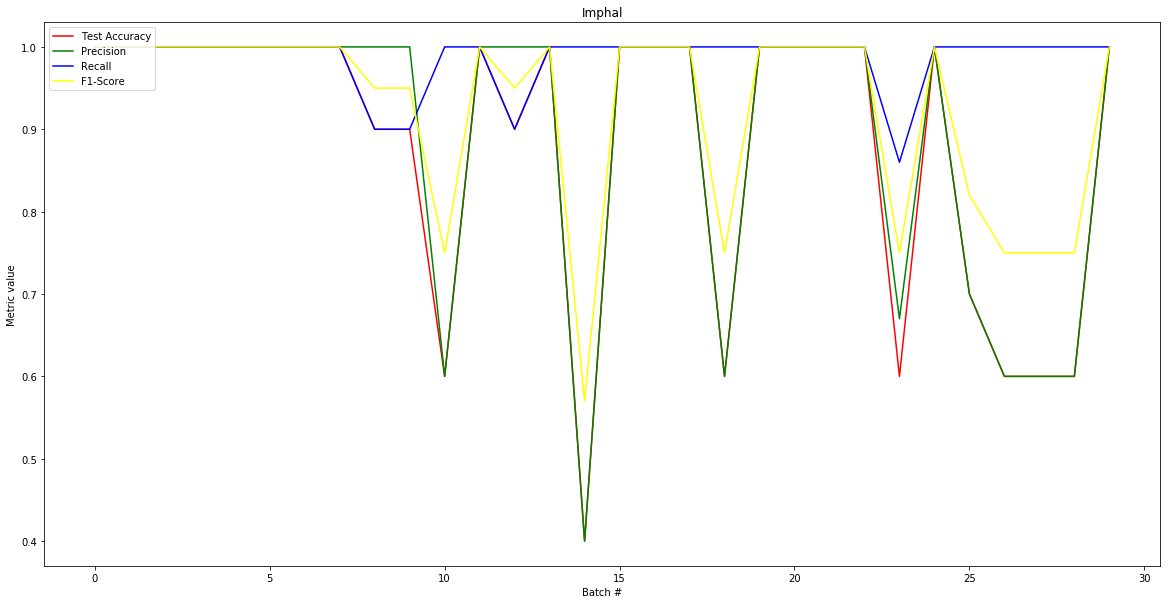

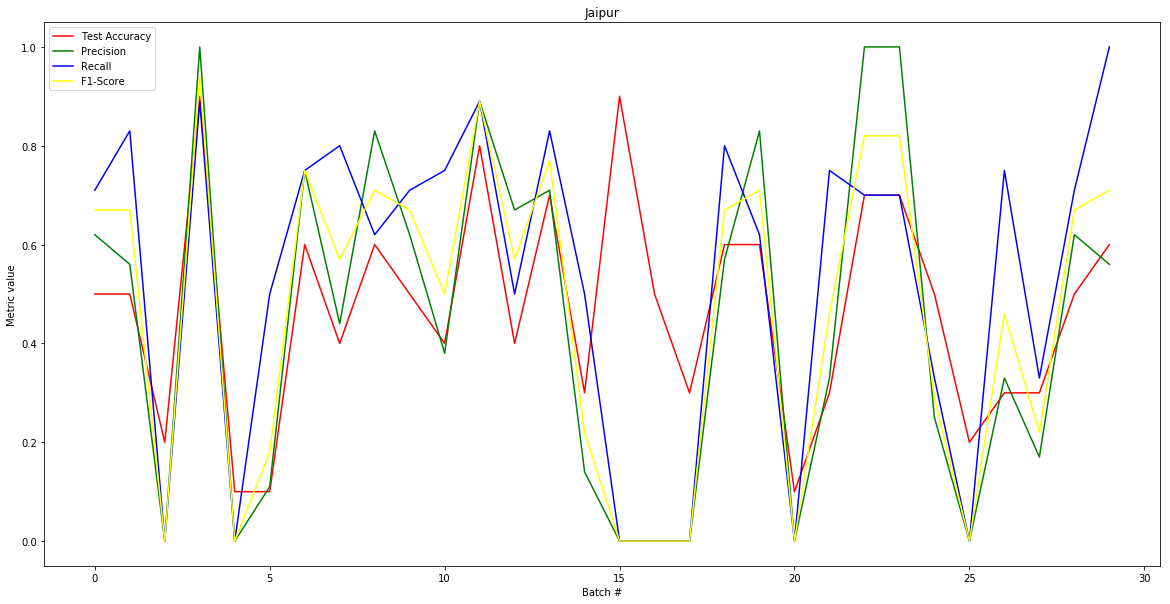

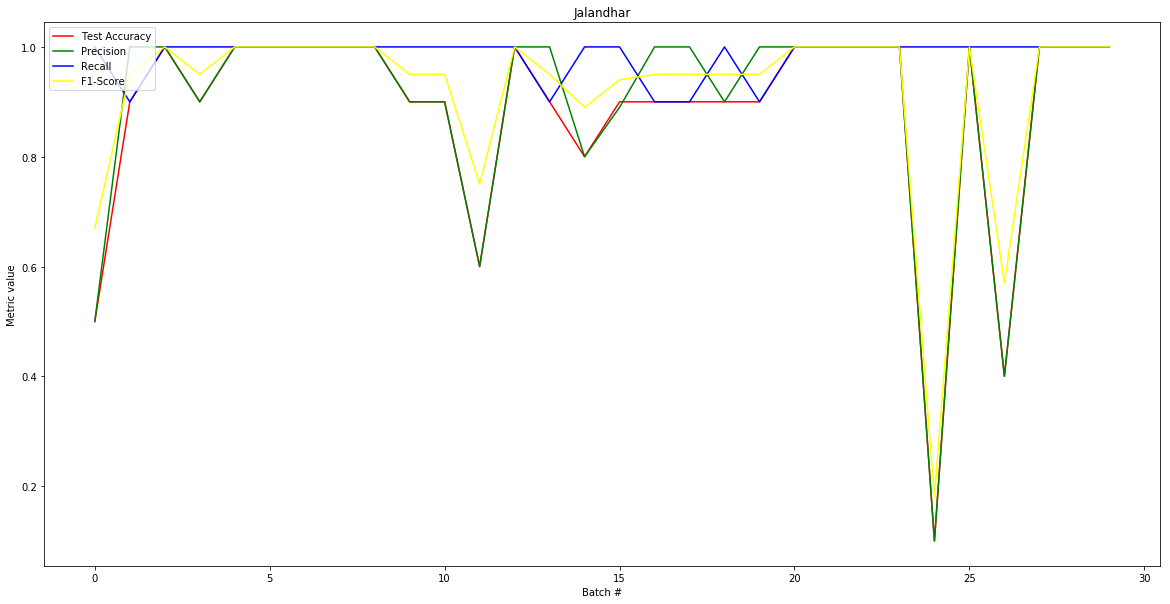

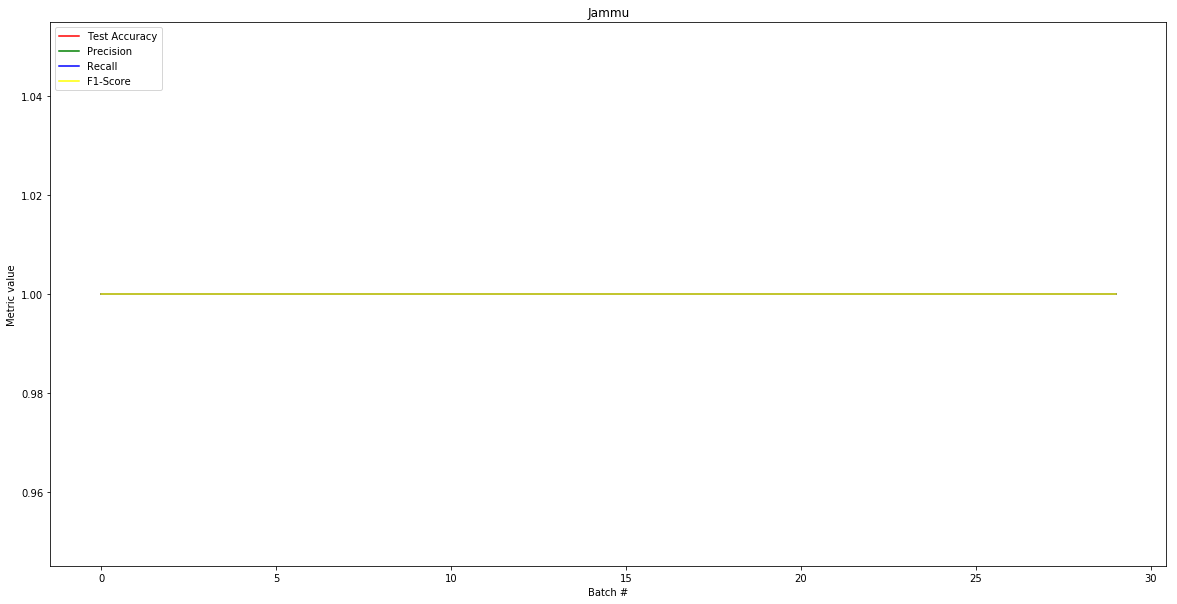

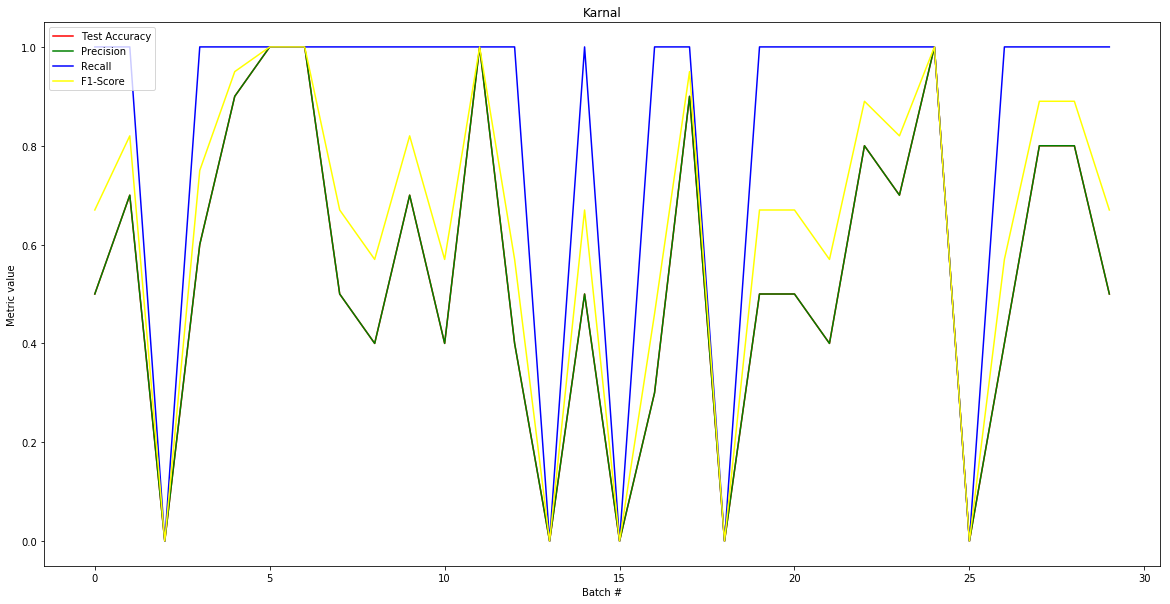

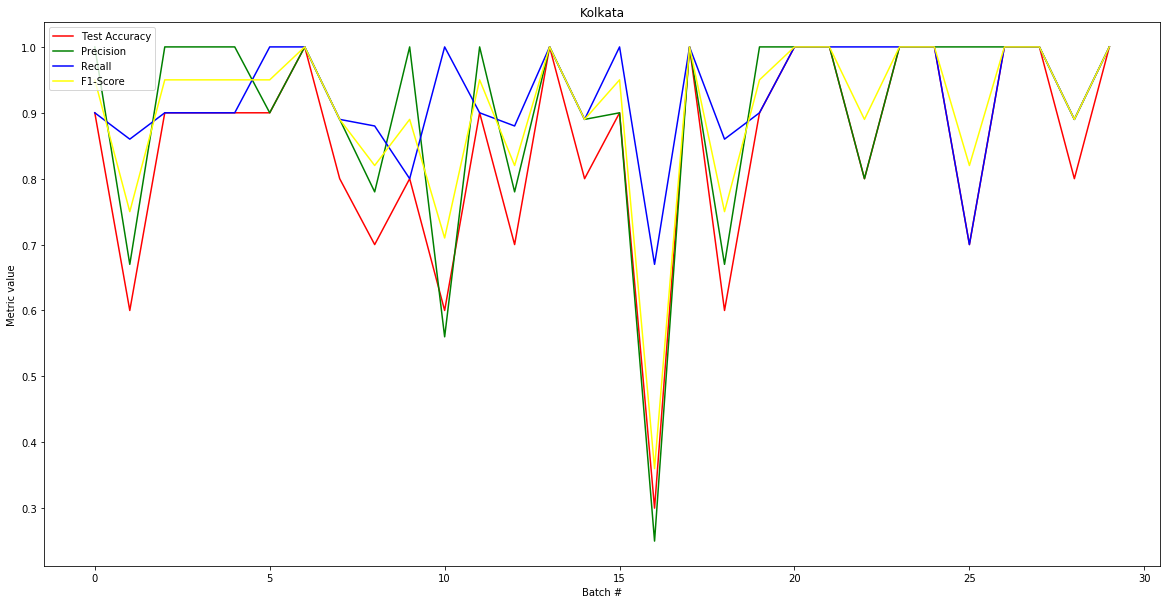

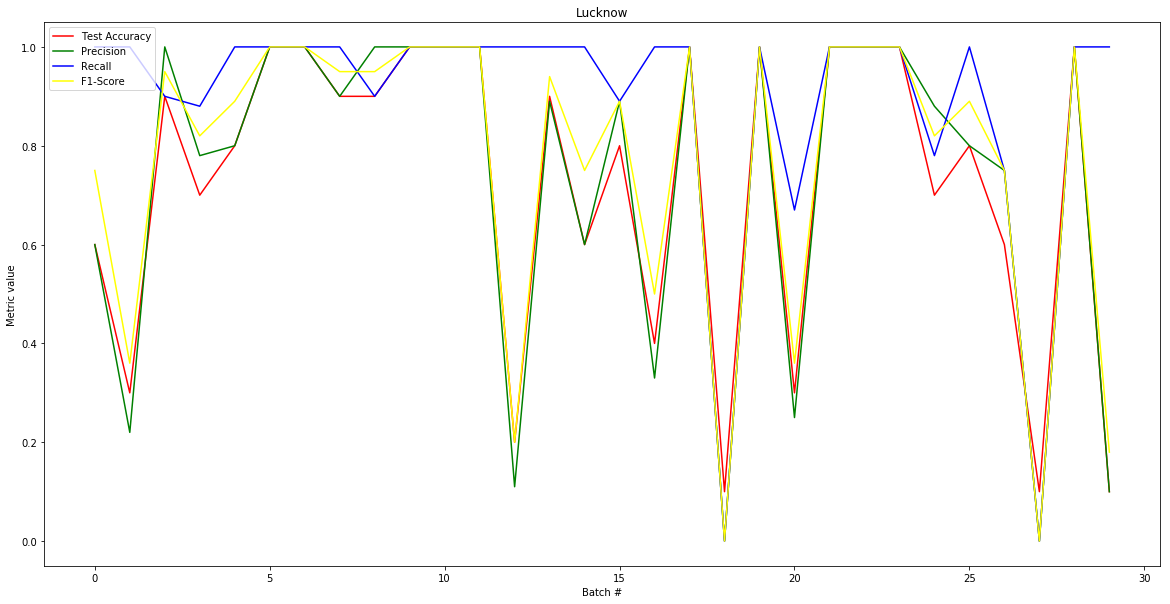

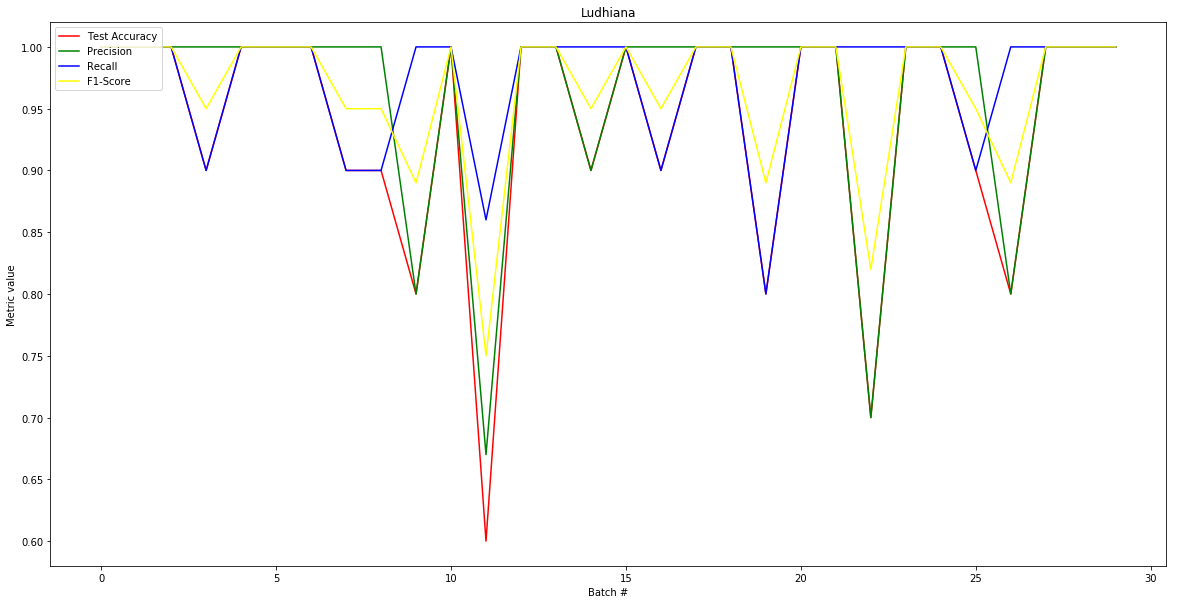

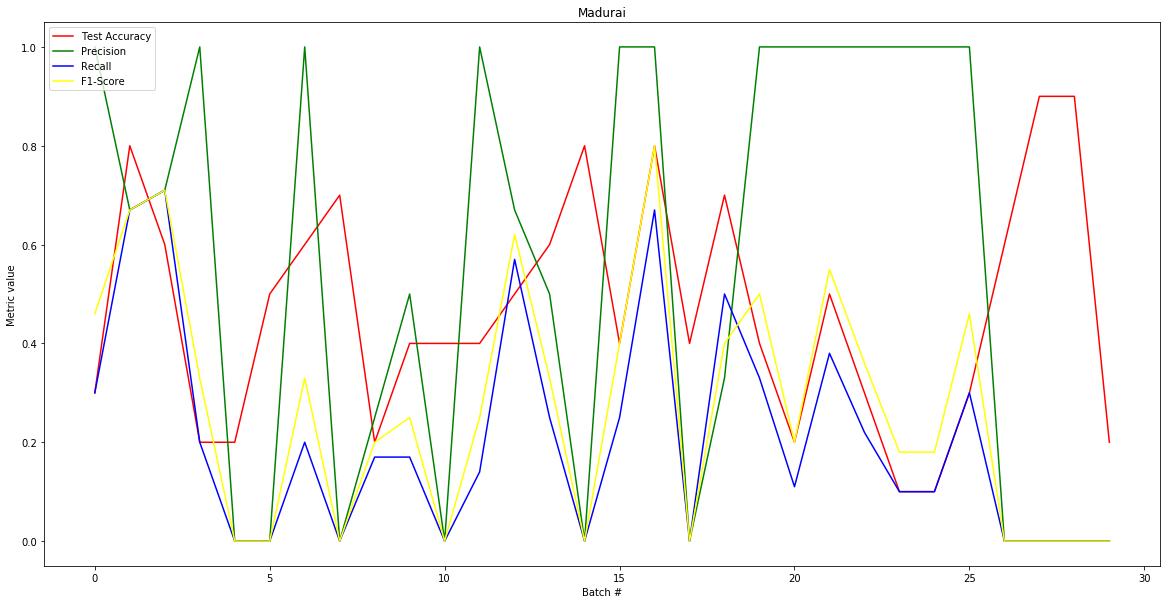

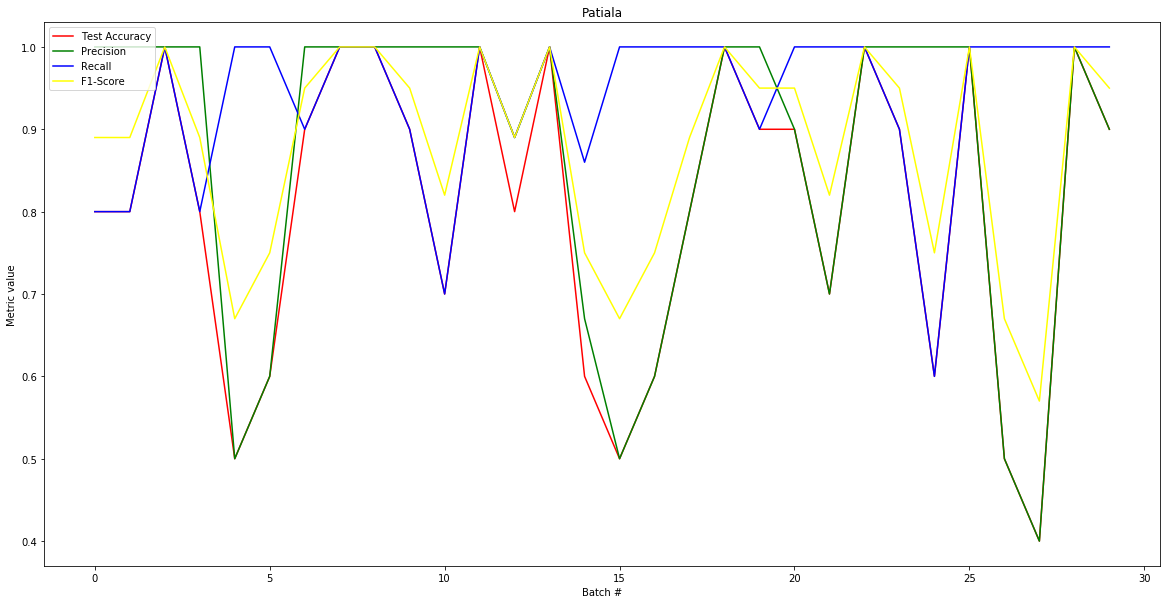

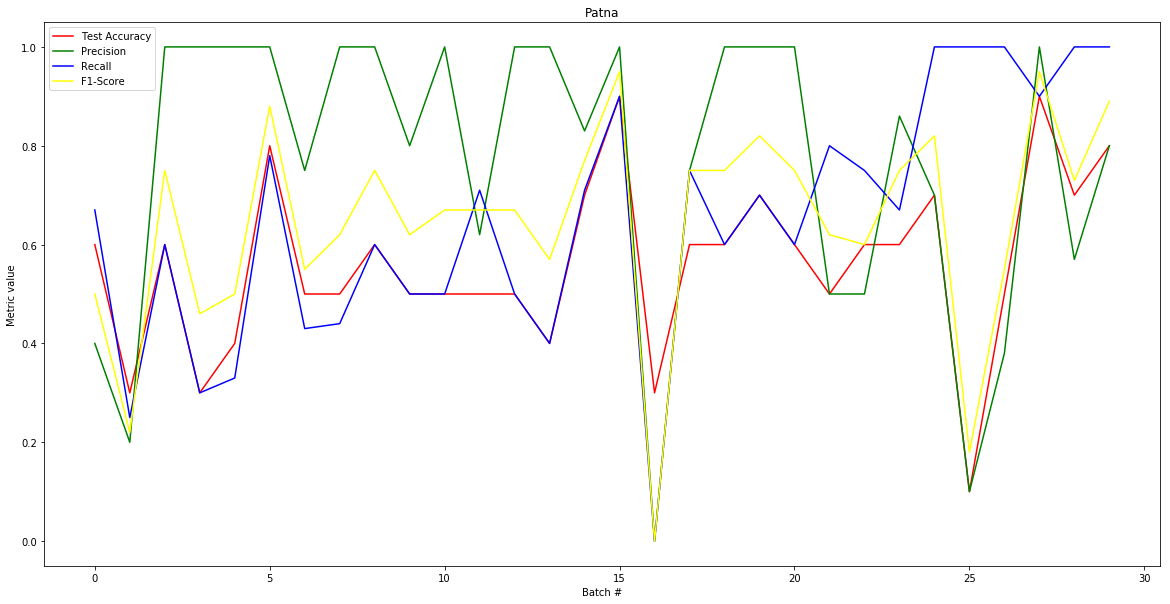

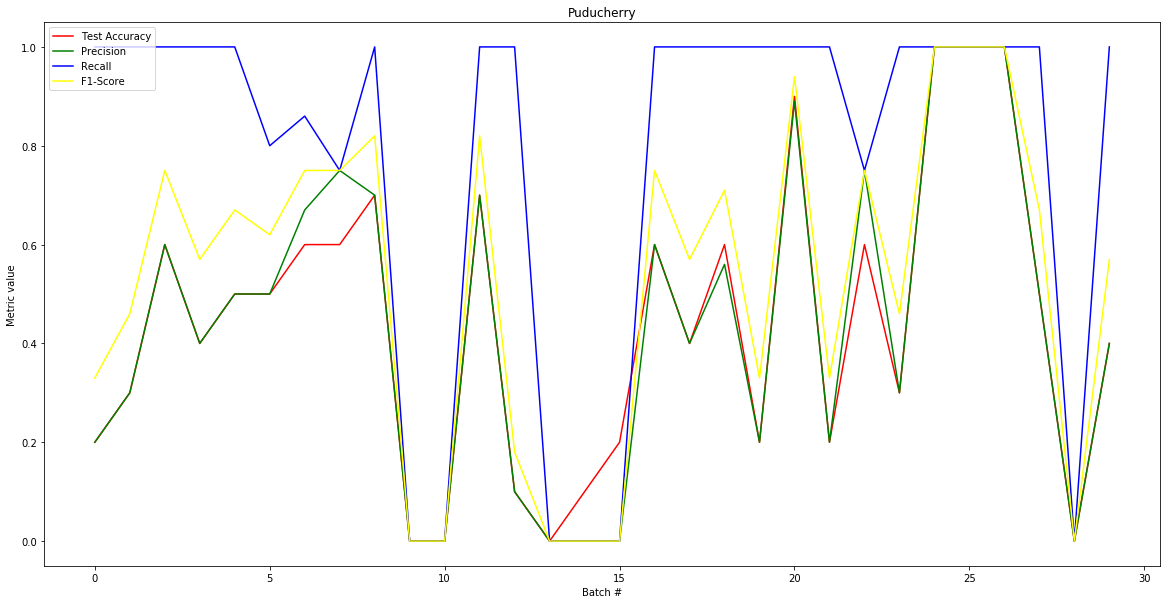

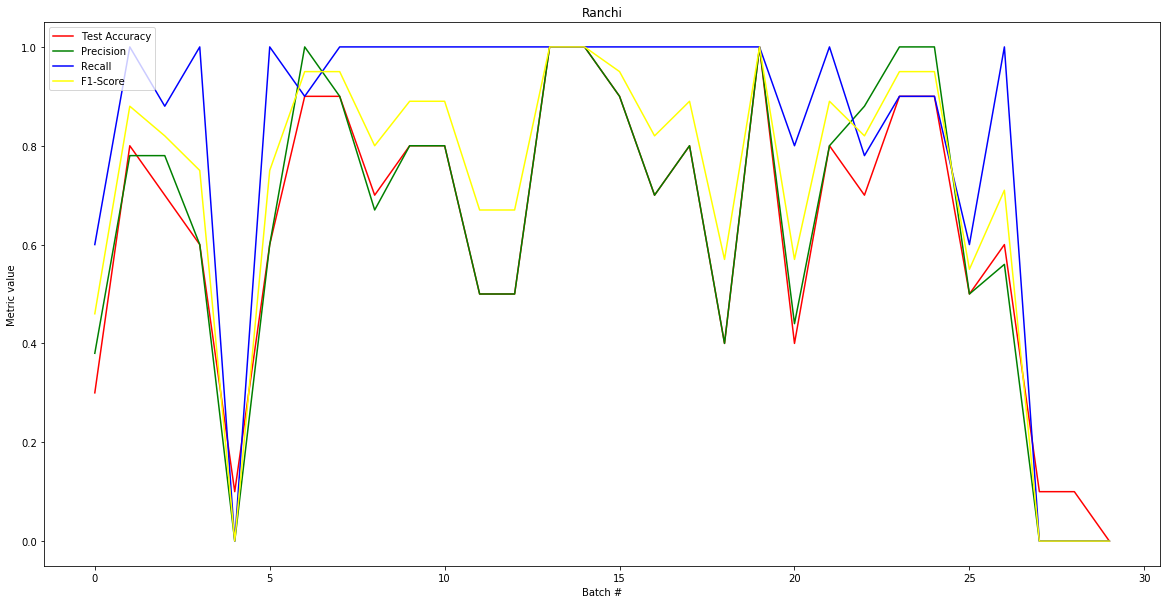

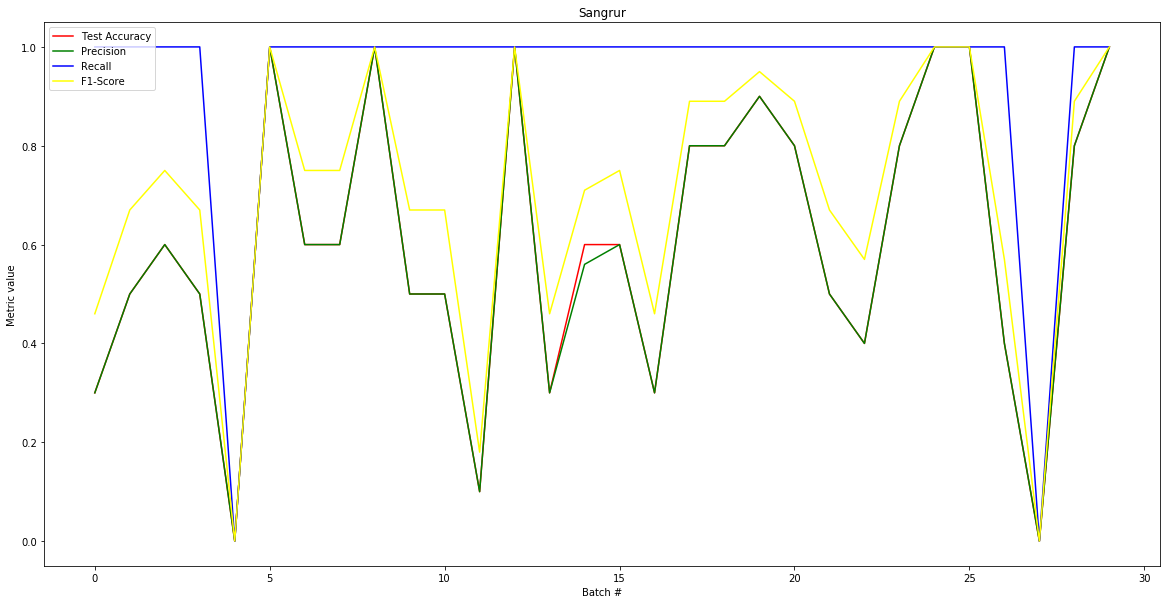

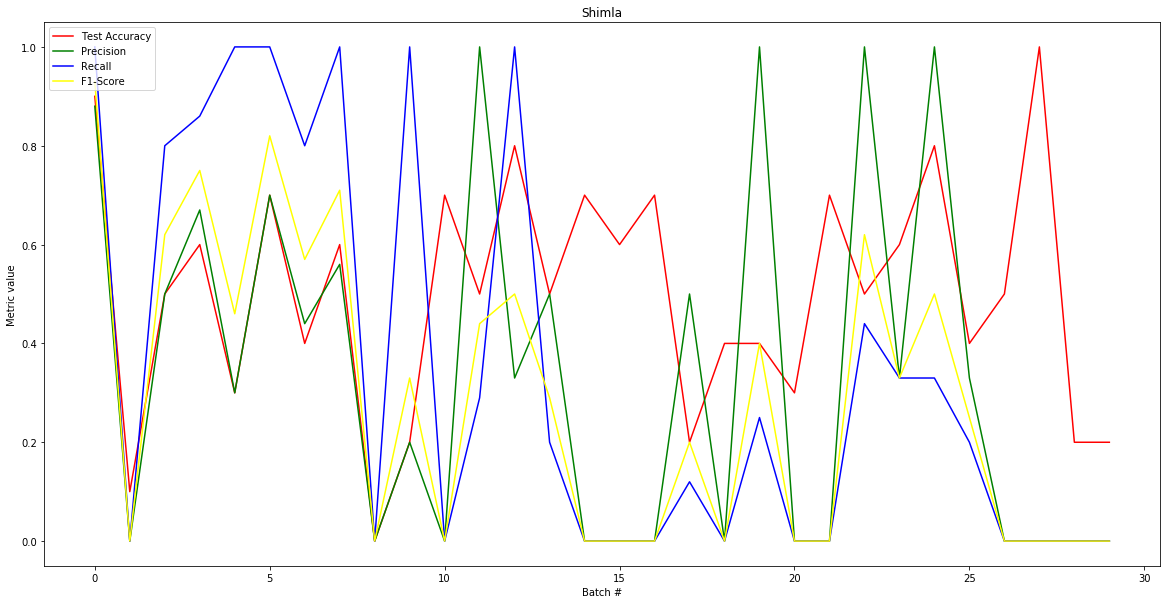

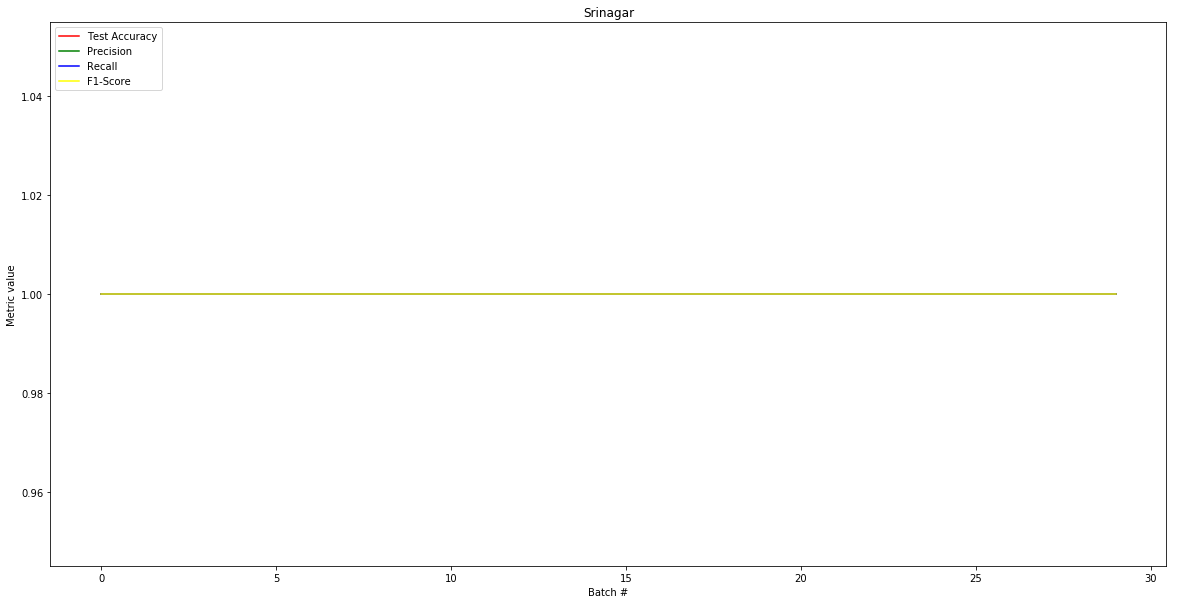

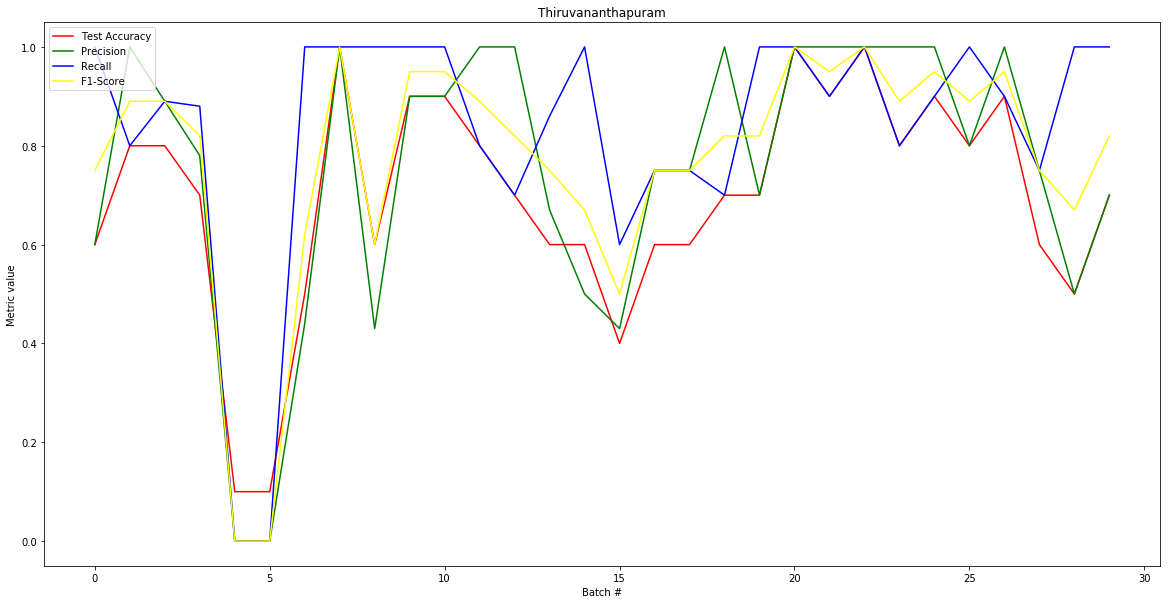

In [154]:
def make_continual_predictions(location_features_dict, labels, model=None, permute=False, lead_days=2, days_window=5, batch_size=20):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
    Returns - None
    """    
    # Suppress warnings for divide-by-zero error
    warnings.filterwarnings("ignore")
    
    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())
    
    # Sorted for clarity
    common_locations = sorted(list(common_locations))
    
    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)
        
        # Table for presenting on tabulate
        result_table = []

        
        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]

        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))
        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]
        
        # Default model
        if model is None:
            model = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)

        # Fit the train data
        model.fit(xtrain, ytrain)
        
        # Get number of test days
        num_test_days = xtest.shape[0]
        
        
        # Test range
        test_range = np.arange(0, num_test_days - batch_size, batch_size)
        
        # Iter through this range
        for i in test_range:
            
            ypred = model.predict(xtest)
            # Get batch and predict for this batch
            ypred_batch = ypred[i: i + batch_size]
            ytest_batch = ytest[i: i + batch_size]
            
            # Compute metrics
            test_acc = np.mean(ypred_batch == ytest_batch)
            precision = precision_score(ytest_batch, ypred_batch)
            recall = recall_score(ytest_batch, ypred_batch)
            f1 = f1_score(ytest_batch, ypred_batch)

            # Add row to result_table
            result_row = [np.round(test_acc, 2),
                          np.round(precision, 2), np.round(recall, 2),
                          np.round(f1, 2)
                         ]
            result_table.append(result_row)
            xtrain = np.vstack((xtrain, xtest[i: i + batch_size]))
            ytrain = np.concatenate((ytrain, ytest_batch))
            model.fit(xtrain, ytrain)
            
        columns = ["Test Accuracy", 
                  "Precision", "Recall",
                  "F1-Score"]
            
        result_df = pd.DataFrame(result_table, columns=columns)
        plot_result_df(result_df, common_location)
        
    warnings.filterwarnings("default")
    return


make_continual_predictions(location_feature_dict, labels, permute=False, batch_size=10)